In [1]:
using LinearAlgebra, Random, JuMP, Ipopt, OSQP, SparseArrays, Plots

# Compile command
run(`gcc N35_BoxQP.c -o N35_BoxQP.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)
run(`gcc N3_BoxQP_dsyr.c -o N3_BoxQP_dsyr.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)

# define the interface call
const N35_BoxQP_lib = "./N35_BoxQP.so"
function call_N35_BoxQP(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N35_BoxQP, N35_BoxQP_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,n,z
    )
    return z
end

const N3_BoxQP_dsyr_lib = "./N3_BoxQP_dsyr.so"
function call_N3_BoxQP_dsyr(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64,delta::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N3_BoxQP_dsyr, N3_BoxQP_dsyr_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,delta,n,z
    )
    return z
end

call_N3_BoxQP_dsyr (generic function with 1 method)

In [2]:
# ProbDim = 50:50:1000
# RunTime_N35 = Float64[]
# RunTime_N3 = Float64[]
# RunTime_Ipopt = Float64[]
# RunTime_OSQP = Float64[]

# epsilon = 1e-6
# alpha = 0.3
# delta = 0.15
# for n in ProbDim
#     num_cond = 1e3
#     num_experiments = ceil(Int, 2000/n)
   
#     run_time_N35 = 0.0
#     run_time_N3 = 0.0
#     run_time_Ipopt = 0.0
#     run_time_OSQP = 0.0 
#     for i in 1:num_experiments
#         v = vcat(num_cond, (num_cond-1)*rand(n-2).+1, 1)
#         U,_ = qr(rand(n,n))
#         H = U*Diagonal(v)*U'
#         h = 1e3*(1 .- 2 .* rand(n))

#         # call N35_BoxQP solver
#         # start_time = time()
#         # z_N35 = call_N35_BoxQP(H,h,epsilon,alpha)
#         # run_time_N35 = run_time_N35 + time() - start_time

#         # call N3_BoxQP solver
#         # start_time = time()
#         # z_N3 = call_N3_BoxQP_dsyr(H,h,epsilon,alpha,delta)
#         # run_time_N3 = run_time_N3 + time() - start_time

#         # call Ipopt solver
#         # model_ipopt = Model(Ipopt.Optimizer)
#         # set_attribute(model_ipopt,"print_level",0)
#         # @variable(model_ipopt,-1.0<=z[i=1:length(h)]<=1.0)
#         # @objective(model_ipopt,Min,0.5*z'*H*z+h'*z)
#         # start_time = time()
#         # optimize!(model_ipopt)
#         # run_time_Ipopt = run_time_Ipopt + time() - start_time


#         # call OSQP solver
#         # model_osqp = OSQP.Model()
#         # OSQP.setup!(model_osqp; P=sparse(H), q=h, A=sparse(I(n)),l=-ones(n),u=ones(n))
#         # start_time = time()
#         # results = OSQP.solve!(model_osqp)
#         # run_time_OSQP =  run_time_OSQP + time() - start_time
#     end
#     # run_time_N35 = run_time_N35/num_experiments
#     # push!(RunTime_N35,run_time_N35)

#     # push!(RunTime_N3,run_time_N3)
#     # run_time_N3 = run_time_N3/num_experiments

#     # run_time_Ipopt = run_time_Ipopt/num_experiments
#     # push!(RunTime_Ipopt,run_time_Ipopt)

#     # run_time_OSQP = run_time_OSQP/num_experiments
#     # push!(RunTime_OSQP,run_time_OSQP)
# end

In [3]:

# plot(ProbDim,RunTime_N35,yscale=:log10,lw=2,marker=:circle,label="Algorithm 1 (dposv)")
# plot!(ProbDim,RunTime_N3,yscale=:log10,lw=2, marker=:circle, label="Algorithm 2 (dsyr)")
# plot(ProbDim,RunTime_Ipopt,yscale=:log10,lw=2,marker=:circle,label="Ipopt")
# plot!(ProbDim,RunTime_OSQP,yscale=:log10,lw=2,marker=:circle,label="OSQP",xlabel="Problem Dimension: n", ylabel="CPU Time (s) (average)",legend=:topleft)

In [4]:
ProbDim = 50:50:1000
RunTime_N35 = Float64[]
RunTime_N3_dsyr = Float64[]
RunTime_Ipopt = Float64[]

for n in ProbDim
    num_cond = 1e3
    v = vcat(num_cond, (num_cond-1)*rand(n-2).+1, 1)
    U,_ = qr(rand(n,n))
    H = U*Diagonal(v)*U'
    h = 1e3*(1 .- 2 .* rand(n))
    
    num_experiments = 5
    
    epsilon = 1e-6
    alpha = 0.3
    start_time = time()
    for i in 1:num_experiments
        z_N35 = call_N35_BoxQP(H,h,epsilon,alpha)
    end
    run_time_N35 = time() - start_time
    run_time_N35 = run_time_N35/num_experiments
    push!(RunTime_N35,run_time_N35)


    epsilon = 1e-6
    alpha = 0.3
    delta = 0.15
    start_time = time()
    for i=1:num_experiments
        z_N3_dsyr = call_N3_BoxQP_dsyr(H,h,epsilon,alpha,delta)
    end
    run_time_N3_dsyr = time() - start_time
    run_time_N3_dsyr = run_time_N3_dsyr/num_experiments
    push!(RunTime_N3_dsyr,run_time_N3_dsyr)

    # call OSQP solver
    # model_osqp = OSQP.Model()
    # OSQP.setup!(model_osqp; P=sparse(H), q=h, A=sparse(I(n)),l=-ones(n),u=ones(n))
    # start_time = time()
    # for i in 1:num_experiments
    #     results = OSQP.solve!(model_osqp)
    # end
    # run_time_OSQP = time() - start_time
    # run_time_OSQP = run_time_OSQP/num_experiments
    # push!(RunTime_OSQP,run_time_OSQP)

    # call Ipopt solver
    model_ipopt = Model(Ipopt.Optimizer)
    set_attribute(model_ipopt,"print_level",0)
    @variable(model_ipopt,-1.0<=z[i=1:length(h)]<=1.0)
    @objective(model_ipopt,Min,0.5*z'*H*z+h'*z)
    start_time = time()
    for i in 1:num_experiments
        optimize!(model_ipopt)
    end
    run_time_Ipopt = time() - start_time
    run_time_Ipopt = run_time_Ipopt/num_experiments
    push!(RunTime_Ipopt,run_time_Ipopt)
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [7]:
ProbDim = 50:50:1000
RunTime_Ipopt = Float64[]

for n in ProbDim
    num_cond = 1e3
    v = vcat(num_cond, (num_cond-1)*rand(n-2).+1, 1)
    U,_ = qr(rand(n,n))
    H = U*Diagonal(v)*U'
    h = 1e3*(1 .- 2 .* rand(n))
    
    num_experiments = 5

    # call Ipopt solver
    model_ipopt = Model(Ipopt.Optimizer)
    set_attribute(model_ipopt,"print_level",0)
    @variable(model_ipopt,-1.0<=z[i=1:length(h)]<=1.0)
    @objective(model_ipopt,Min,0.5*z'*H*z+h'*z)
    start_time = time()
    for i in 1:num_experiments
        optimize!(model_ipopt)
    end
    run_time_Ipopt = time() - start_time
    run_time_Ipopt = run_time_Ipopt/num_experiments
    push!(RunTime_Ipopt,run_time_Ipopt)
end

In [5]:
ProbDim = 50:50:1000
RunTime_OSQP = Float64[]

for n in ProbDim
    num_cond = 1e3
    v = vcat(num_cond, (num_cond-1)*rand(n-2).+1, 1)
    U,_ = qr(rand(n,n))
    H = U*Diagonal(v)*U'
    h = 1e3*(1 .- 2 .* rand(n))
    
    num_experiments = 5

    model_osqp = OSQP.Model()
    OSQP.setup!(model_osqp; P=sparse(H), q=h, A=sparse(I(n)),l=-ones(n),u=ones(n))
    start_time = time()
    for i in 1:num_experiments
        results = OSQP.solve!(model_osqp)
    end
    run_time_OSQP = time() - start_time
    run_time_OSQP = run_time_OSQP/num_experiments
    push!(RunTime_OSQP,run_time_OSQP)
end

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 50, constraints m = 50
          nnz(P) + nnz(A) = 1325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.7611e+04   1.64e+00   4.07e+02   1.00e-01   2.31e-04s
  25  -1.8353e+04   1.50e-05   1.94e-03   1.00e-01   2.96e-04s

status:               solved
number of iterat

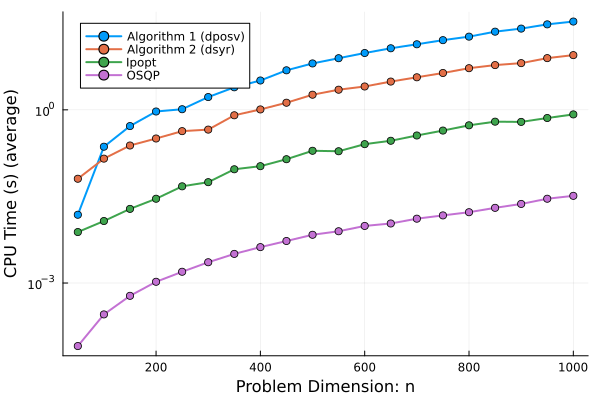

In [8]:
plot(ProbDim,RunTime_N35,yscale=:log10,lw=2,marker=:circle,label="Algorithm 1 (dposv)")
plot!(ProbDim,RunTime_N3_dsyr,yscale=:log10,lw=2, marker=:circle, label="Algorithm 2 (dsyr)")
plot!(ProbDim,RunTime_Ipopt,yscale=:log10,lw=2,marker=:circle,label="Ipopt")
plot!(ProbDim,RunTime_OSQP,yscale=:log10,lw=2,marker=:circle,label="OSQP",xlabel="Problem Dimension: n", ylabel="CPU Time (s) (average)",legend=:topleft)